

Contents:


1.   Imports
2.   Dataset preparation

3.   Model building
4.   Model evaluation









(1) Imports

In [ ]:
#IMPORTS
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras import layers
from keras import optimizers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tarfile
import os
import cv2
import numpy as np
import pandas as pd

(2) Dataset preparation

In [ ]:
#DATASET EXTRACTION
tar = tarfile.open('/content/drive/MyDrive/Appsilon_Assignment/data/17flowers.tgz','r')
tar.extractall()

In [ ]:
#ONE HOT ENCODING FOR THE 17 CATEGORIES
classes = [ i for i in range(0,17) ]
y = np.repeat(classes, 80)
y = tf.keras.utils.to_categorical(y, num_classes=17, dtype='float32')

In [ ]:
#DATA PREPARATION
images = []
loc = os.path.expanduser('/content/drive/MyDrive/Appsilon_Assignment/data/jpg')

for filename in sorted(os.listdir(loc)):

    img = cv2.imread(os.path.join(loc,filename))

    if img is not None:
        img = cv2.resize(img, dsize=(224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

images = np.asarray(images)

In [ ]:
#DATASET SPLIT INTO TRAIN AND VALIDATION SET IN 80:20 RATIO
X_train, X_val, y_train, y_val = train_test_split(images, y, test_size=0.2, random_state=0)

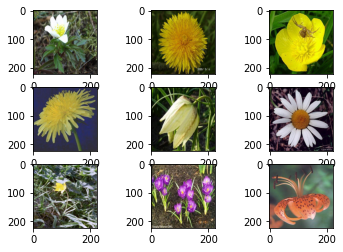

In [ ]:
#PLOTTING FIRST FEW IMAGES
for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(X_train[i])
plt.show()

In [ ]:
#IMAGE SIZE
images.shape

(1360, 224, 224, 3)

In [ ]:
#DATA AUGMENTATION
train_datagen = ImageDataGenerator (rescale=1./255,
                                    brightness_range=[0.1, 0.7],
                                    featurewise_std_normalization=True,
                                    zoom_range=0.2,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator (rescale=1./255, featurewise_std_normalization=True)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


(3) Model building

In [ ]:
#IMPORTING VGG16 LIBRARY
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#RETAINING EXISTING WEIGHTS OF THE MODEL
for layer in conv_base.layers:
  layer.trainable = False

# fine_tune=2

# if fine_tune > 0:
#     for layer in conv_base.layers[:-fine_tune]:
#         layer.trainable = False
# else:
#     for layer in conv_base.layers:
#         layer.trainable = False

In [ ]:
#BUILDING SEQUENTIAL MODEL BY ADDING LAYERS
model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(filters=64, kernel_initializer='he_uniform', kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=64, kernel_initializer='he_uniform', kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_initializer='he_uniform', kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=64,kernel_initializer='he_uniform', kernel_size=(3,3),padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(layers.Dense(17, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 64)          294976    
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 64)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          3

(4) Model evaluation

In [ ]:
#MODEL CHECKPOINT CALLBACK
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Appsilon_Assignment/model/final_model_best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

#EARLY STOPPING
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
batch_size = 32
ntrain = len(X_train)
nval = len(X_val)

#COMPILE AND FIT MODEL
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    steps_per_epoch = ntrain // batch_size,
    validation_steps = nval // batch_size,
    callbacks=[early_stop, checkpointer]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 3.4204 - accuracy: 0.0717 
Epoch 1: val_loss improved from inf to 2.78972, saving model to /content/drive/MyDrive/Appsilon_Assignment/model/final_model_best.hdf5
34/34 [==============================] - 609s 18s/step - loss: 3.4204 - accuracy: 0.0717 - val_loss: 2.7897 - val_accuracy: 0.1172
Epoch 2/100
 1/34 [..............................] - ETA: 10:32 - loss: 3.0314 - accuracy: 0.0938

KeyboardInterrupt: ignored

In [ ]:
#SUMMARIZE DIAGNOSTICS
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel("Epoch #")
plt.ylabel("Loss");
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy");